In [138]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from skimage.draw import polygon2mask
from scipy import ndimage
from PIL import Image
from src.preprocessing import process_image, process_video
from skimage.color import label2rgb
from skimage.morphology import label
from IPython.display import display, clear_output
from skimage.measure import regionprops

In [139]:
label_video = process_video('images/cheese_gel.avi', threshold=0.2, skip_size=8)

In [140]:
# for image in label_video:
#     fig = plt.imshow(image)
#     plt.show()
#     plt.pause(1)
#     plt.close()

In [141]:
# shape = label_video.shape[1], label_video.shape[2]

# L = 100 # Maximum distances to consider
# M = shape[0] - L

# label_image_bounded = np.zeros(shape, dtype=int)
# regions = regionprops(label_image)
# cluster_num = 1
# for props in regions:
#     minr, minc, maxr, maxc = props.bbox
#     if (minr > L+1) & (minc > L+1) & (maxr < M+1) & (maxc < M+1):
#         pixel_coordinates = props.coords
#         label_image_bounded[pixel_coordinates[:,0],  pixel_coordinates[:,1]] =  cluster_num
#         cluster_num += 1

In [142]:
# fig, ax = plt.subplots(1,4, figsize=(14,6), gridspec_kw={'width_ratios': [1, 1, 1, 2]})
# fig.subplots_adjust(wspace=0.4)
# plt.tight_layout()

# for label_image in label_video:
#     print(label_image)
#     ax[3].imshow(label2rgb(label_image, bg_label=0))
#     display(fig)
#     clear_output(wait = True)
# plt.show()
    

(1002, 1002)
100 902


KeyboardInterrupt: 

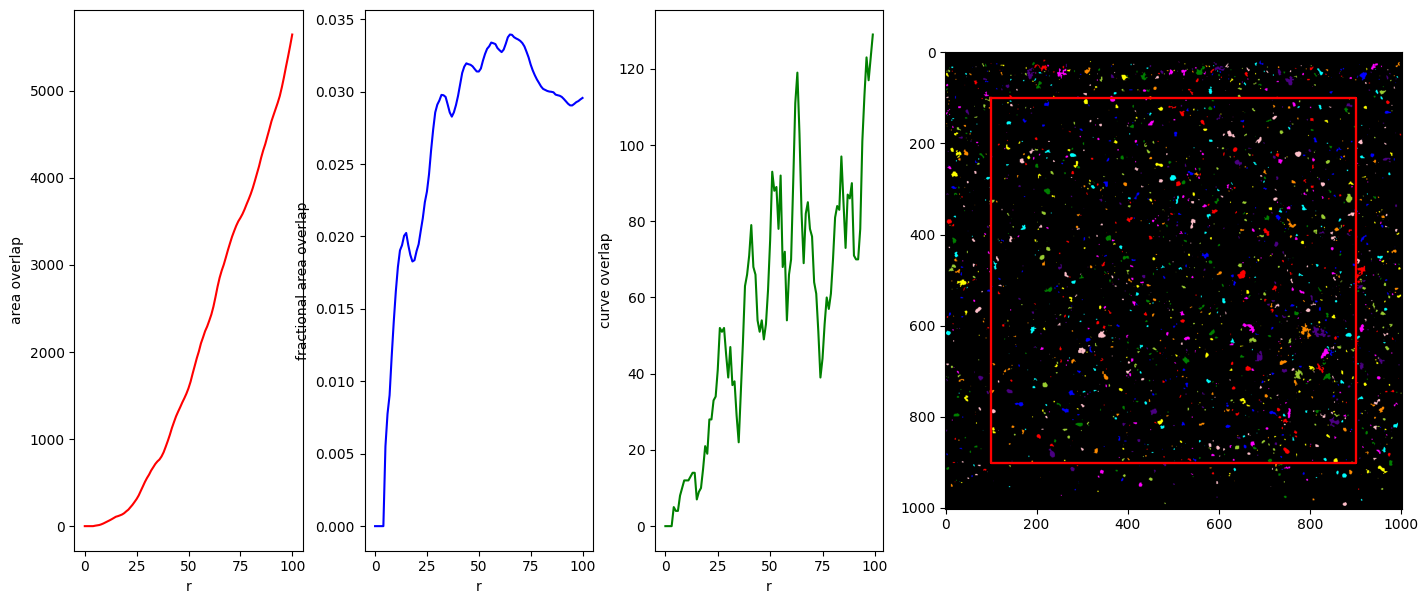

In [151]:
fig, ax = plt.subplots(1,4, figsize=(14,6), gridspec_kw={'width_ratios': [1, 1, 1, 2]})
fig.subplots_adjust(wspace=0.4)
plt.tight_layout()

for label_image in label_video:
    print(label_image.shape)
    a = regionprops(label_image)

    L = 100 # Maximum distances to consider
    M = label_image.shape[0] - L
    print(L,M)

    label_image_bounded = np.zeros(label_image.shape, dtype=int)
    cluster_num = 1
    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        if (minr > L+1) and (minc > L+1) and (maxr < M-1) and (maxc < M-1):
            pixel_coordinates = region.coords
            label_image_bounded[pixel_coordinates[:,0],  pixel_coordinates[:,1]] =  cluster_num
            cluster_num += 1


    bx = (L, M, M, L, L)
    by = (L, L, M, M, L)
    ax[3].plot(bx, by, '-r')
    ax[3].imshow(label2rgb(label_image, bg_label=0))
    curr_image = label_image_bounded

    F = np.zeros(L+1)
    G = np.zeros(L+1)
    for cluster in range(1, curr_image.max()+1):
        ref_cluster = curr_image == cluster
        rem_clusters = label_image * np.invert(ref_cluster)
        
        D = ndimage.distance_transform_edt(ref_cluster==0)
        f = np.zeros(L+1)
        g = np.zeros(L+1)
        for i in range(0,L+1):
            K = D <= i
            f[i] = np.count_nonzero(K*rem_clusters)
            g[i] = np.count_nonzero(K)
            
        F += f
        G += g 

    F = F / curr_image.max()
    G = G / curr_image.max()

    ax[0].plot(F, 'r')
    ax[0].set_xlabel('r')
    ax[0].set_ylabel('area overlap')

    ax[1].plot(F/G, 'b')
    ax[1].set_xlabel('r')
    ax[1].set_ylabel('fractional area overlap')

    ax[2].plot(F[1:]-F[:-1], 'g')
    ax[2].set_xlabel('r')
    ax[2].set_ylabel('curve overlap')
    display(fig)
    clear_output(wait = True)
plt.show()